In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "careamics[examples]>=0.0.15",
# ]
# ///


The U2OS dataset is composed of pairs of noisy and high SNR nuclei images acquired in 
fluorescence microscopy. They were originally used in Weigert et al (2018) to showcase
CARE denoising.

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics import CAREamist
from careamics.config import create_care_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager
from PIL import Image

In [3]:
use_gpu  = "yes" if len([torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]) > 0 else "no"
print(f"Using GPU: {use_gpu}")


Using GPU: yes


## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

The CARE U2OS dataset is composed of thousands of examples organized in train and test:

- train
    - low: low SNR data
    - GT: high SNR data
- test
    - low: low SNR data
    - GT: high SNR data
 


In [4]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
download = portfolio.denoising.CARE_U2OS.download(root_path)

# path to the training data
root_path = root_path / "denoising-CARE_U2OS.unzip" / "data" / "U2OS"
train_path = root_path / "train" / "low"
target_path = root_path / "train" / "GT"

100%|███████████████████████████████████████| 797M/797M [00:00<00:00, 1.33TB/s]
Unzipping contents of '/localscratch/careamics-examples/applications/care/denoising/2D/data/denoising-CARE_U2OS' to '/localscratch/careamics-examples/applications/care/denoising/2D/data/denoising-CARE_U2OS.unzip'


## Visualize data

Text(0.5, 1.0, 'Target image')

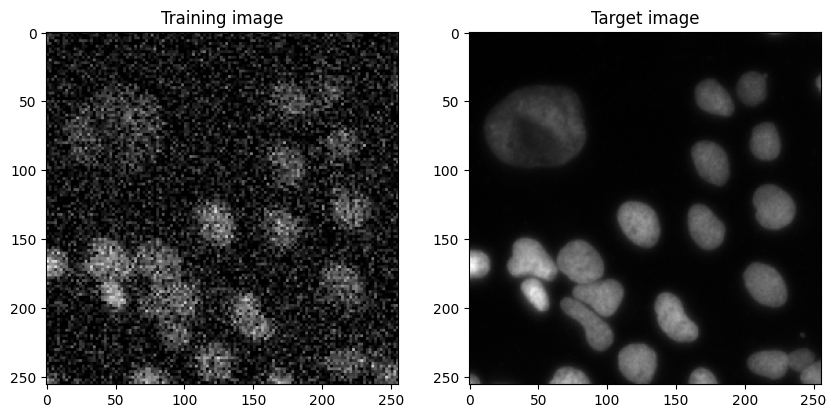

In [5]:
# load training image and target, and show them side by side
train_files = list(train_path.rglob("*.tif"))
train_files.sort()

target_files = list(target_path.rglob("*.tif"))
target_files.sort()

# select random example
ind = np.random.randint(len(train_files))
train_image = tifffile.imread(train_files[ind])
train_target = tifffile.imread(target_files[ind])

# plot the two images and a crop
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[00].set_title("Training image")

ax[1].imshow(train_target, cmap="gray")
ax[1].set_title("Target image")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [6]:
config = create_care_configuration(
    experiment_name="care_U20S",
    data_type="tiff",
    axes="YX",
    patch_size=(128, 128),
    batch_size=32,
    num_epochs=100,
)

print(config)

{'algorithm_config': {'algorithm': 'care',
                      'loss': 'mae',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'optimizer': {'name': 'Adam', 'parameters': {}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 32,
                 'data_type': 'tiff',
                 'patch_size': [128, 128],
                 'train_dataloader_params': 

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [7]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_path,
    train_target=target_path,
    val_percentage=0.01,
    val_minimum_split=20,
)

No working directory provided. Using current working directory: /localscratch/careamics-examples/applications/care/denoising/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Extracted 9828 patches from input array.
Computed dataset mean: [10.38048842], std: [11.92320034]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 333 K  | train
---------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated mode

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Show loss curves.

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


Text(0.5, 1.0, 'Losses')

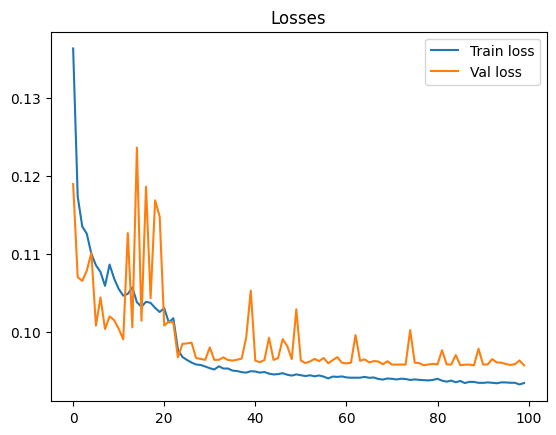

In [13]:
loss_dict = careamist.get_losses()
plt.plot(loss_dict["train_epoch"], loss_dict["train_loss"], loss_dict["val_epoch"], loss_dict["val_loss"])
plt.legend(["Train loss", "Val loss"])
plt.title("Losses")

## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training, and we can use the test
set.

In [8]:
test_path = root_path / "test" / "low"

prediction = careamist.predict(source=test_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-gplz1jqb-985de71f5ff5192e/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualize the prediction

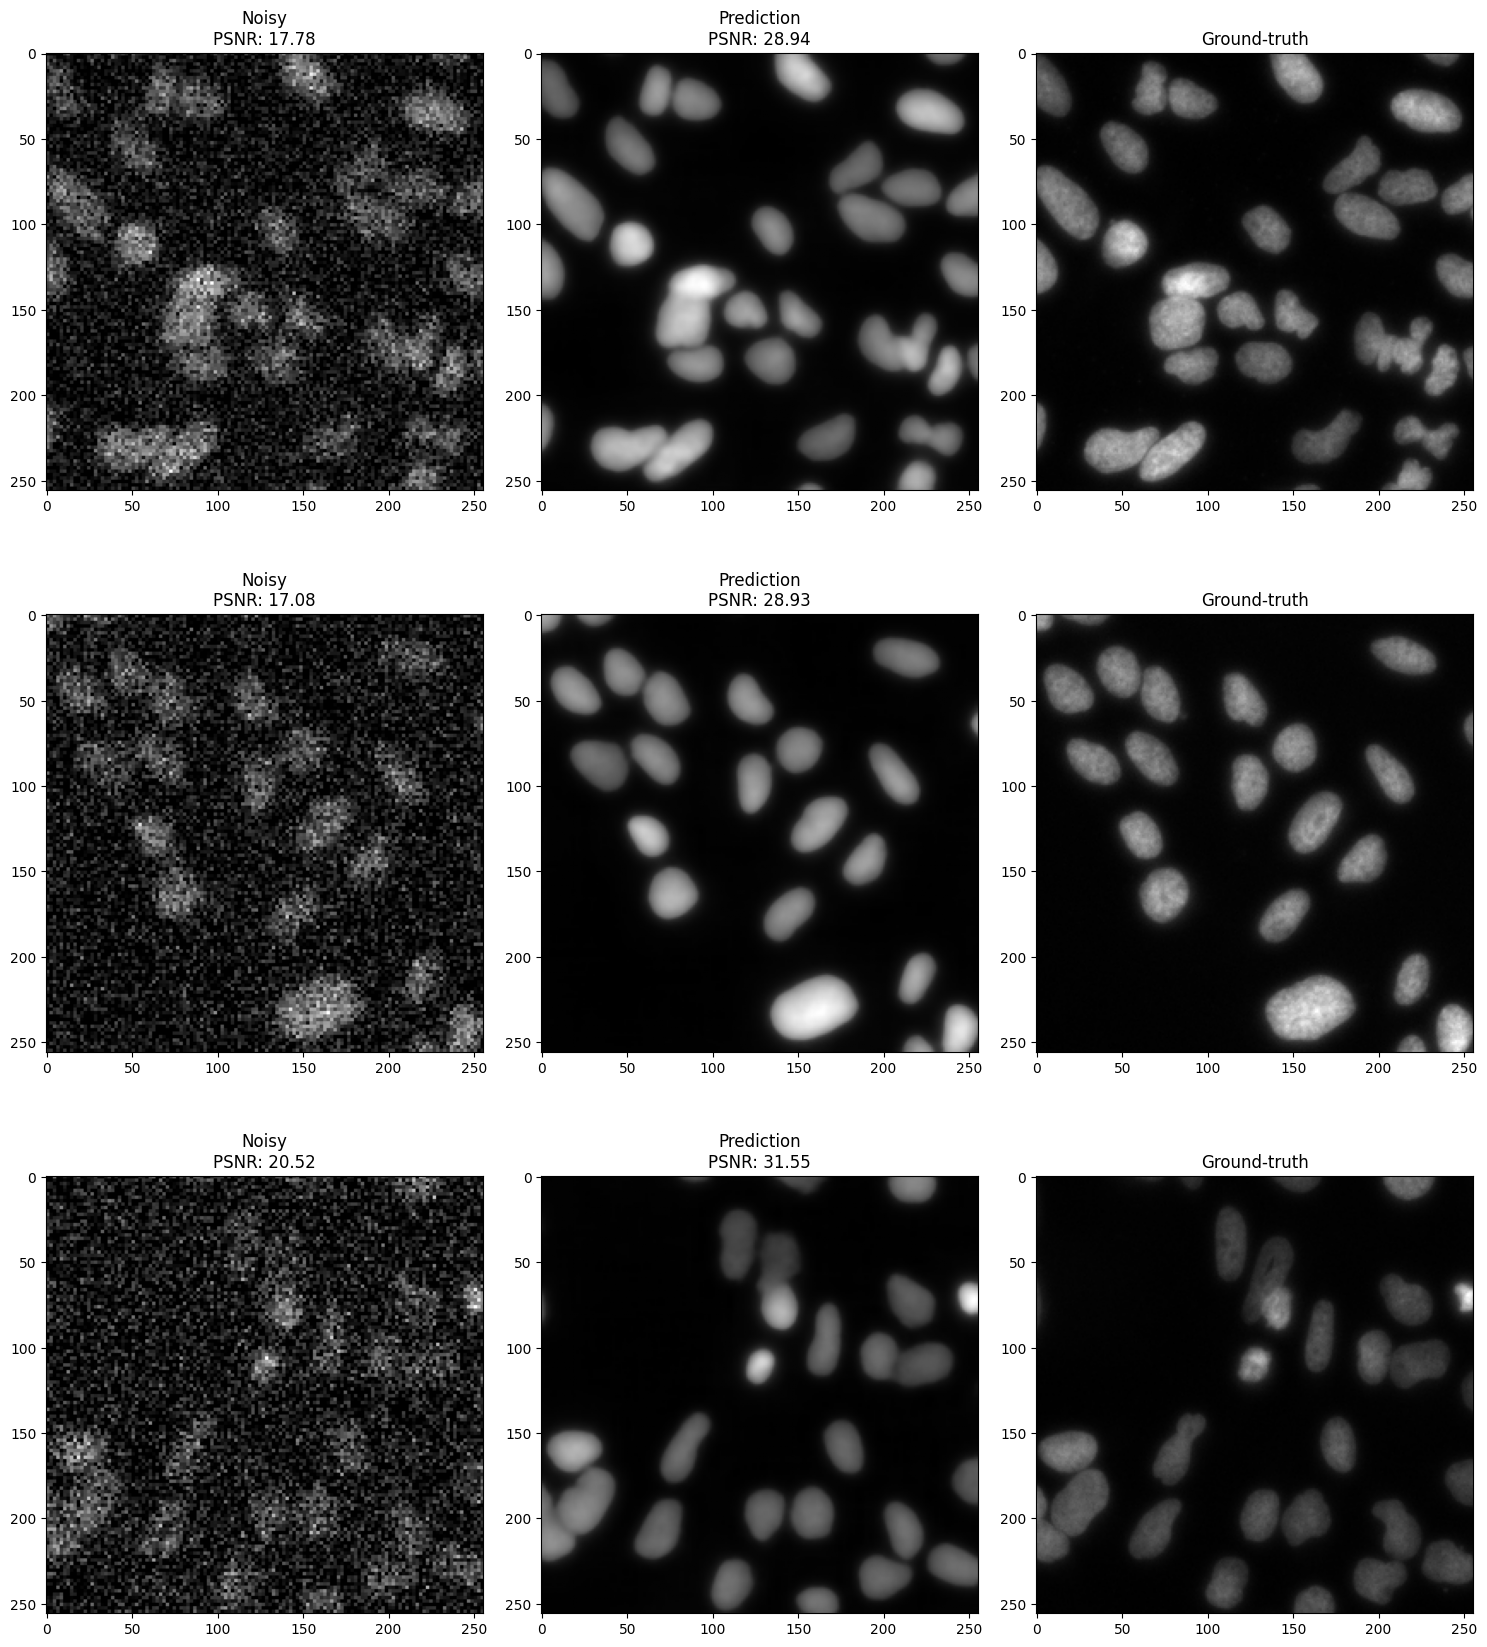

In [9]:
# Show two images
test_GT_path = root_path / "test" / "GT"
test_GT_files = list(test_GT_path.rglob("*.tif"))
test_GT_files.sort()

test_low_path = root_path / "test" / "low"
test_low_files = list(test_low_path.rglob("*.tif"))
test_low_files.sort()

test_GT = [tifffile.imread(f) for f in test_GT_files]
test_low = [tifffile.imread(f) for f in test_low_files]

# images to show
images = np.random.choice(range(len(test_GT)), 3)

fig, ax = plt.subplots(3, 3, figsize=(15, 17))
fig.tight_layout()

for i in range(3):
    pred_image = prediction[images[i]].squeeze()

    psnr_noisy = scale_invariant_psnr(test_GT[images[i]], test_low[images[i]])
    psnr_result = scale_invariant_psnr(test_GT[images[i]], pred_image)

    ax[i, 0].imshow(test_low[images[i]], cmap="gray")
    ax[i, 0].title.set_text(f"Noisy\nPSNR: {psnr_noisy:.2f}")

    ax[i, 1].imshow(pred_image, cmap="gray")
    ax[i, 1].title.set_text(f"Prediction\nPSNR: {psnr_result:.2f}")

    ax[i, 2].imshow(test_GT[images[i]], cmap="gray")
    ax[i, 2].title.set_text("Ground-truth")

### Compute metrics

In [10]:
psnrs = np.zeros((len(prediction), 1))

for i, (pred, gt) in enumerate(zip(prediction, test_GT)):
    psnrs[i] = scale_invariant_psnr(gt, pred.squeeze())

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")

PSNR: 31.52 +/- 3.71


## Create cover

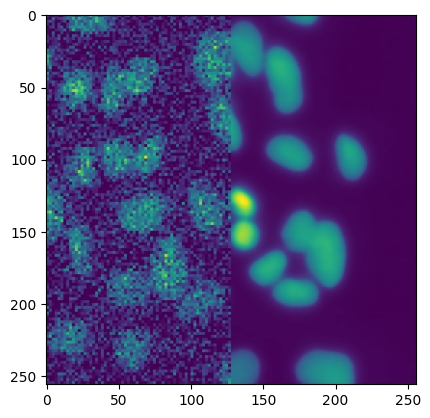

In [11]:
# create a cover image
im_idx = 17
cv_image_noisy = test_low[im_idx]
cv_image_pred = prediction[im_idx].squeeze()

# create image
cover = np.zeros_like(cv_image_noisy, dtype=np.float32)
width = cover.shape[1]

# # normalize train and prediction
norm_noise = (cv_image_noisy - cv_image_noisy.min()) / (
    cv_image_noisy.max() - cv_image_noisy.min()
)
norm_pred = (cv_image_pred - cv_image_pred.min()) / (
    cv_image_pred.max() - cv_image_pred.min()
)

# fill in halves
cover[:, : width // 2] = norm_noise[:, : width // 2]
cover[:, width // 2 :] = norm_pred[:, width // 2 :]

# plot the single image
plt.imshow(cover)

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("U2OS_CARE.jpeg")